# 実践コンピュータビジョン
## 5章 多視点幾何

### オックスフォード多視点データセット
下記のURLからデータをダウンロードする  
http://www.robots.ox.ac.uk/~vgg/data/data-mview.html

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
%matplotlib inline

## 5.1 エピポーラ幾何
### 5.1.1 サンプルデータセット
テキストp.105

In [39]:
# オリジナルモジュール
import camera

In [40]:
# 画像を読み込む
im1 = np.array(Image.open('images/001.jpg'))
im2 = np.array(Image.open('images/002.jpg'))

In [41]:
# 各画像上の2Dの点をリストに読み込む
points2D = [np.loadtxt('2D/00'+str(i+1)+'.corners').T for i in range(3)]

In [42]:
# 3Dの点を読み込む
points3D = np.loadtxt('3D/p3d').T

### np.genfromtxt()
genfromtxt()は欠損値を-1で置き換える。
読み込むファイルnview-cornersでは欠損値を * で表記しているため、<br>
missing_valuesオプションで指定する。

ただしnumpy 1.10以降ではオプションの missing はmissing_values に変わったため、<br>
オプションはmissingではなく、missing_valuesとする。

```python
corr = np.genfromtxt('2D/nview-corners',dtype='int',missing='*')  # テキスト掲載のコード
corr = np.genfromtxt('2D/nview-corners', dtype='int', missing_values='*') #　修正後
```

詳細はnumpy documentation  
http://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt

In [43]:
# 対応関係を読み込む
corr = np.genfromtxt('2D/nview-corners', dtype='int', missing_values='*')
corr

array([[  0,  -1,   0],
       [  1,   0,  -1],
       [  2,   1,  -1],
       ..., 
       [639, 665, 511],
       [640, 666, 512],
       [641, 667, 513]])

In [44]:
# カメラパラメータをCameraオブジェクトに読み込む
P = [camera.Camera(np.loadtxt('2D/00'+str(i+1)+'.P')) for i in range(3)]

In [45]:
# 3Dの点を同次座標にして射影する
X = np.vstack((points3D, np.ones(points3D.shape[1])))
x = P[0].project(X)

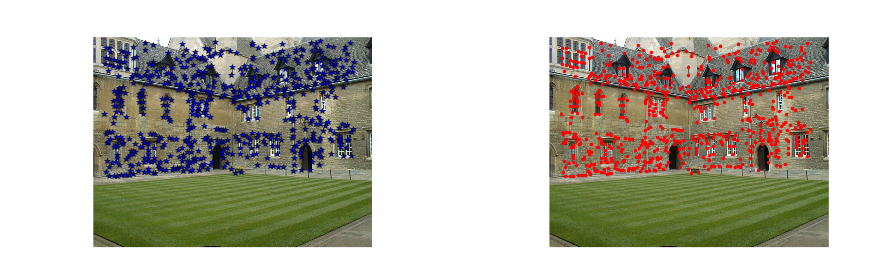

In [46]:
# 画像1の上に点を描画する
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im1)
plt.plot(points2D[0][0], points2D[0][1], '*')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(im1)
plt.plot(x[0], x[1], 'r.')
plt.axis('off')

plt.show()

### 5.1.2 Matplotlibによる3Dデータの描画
テキストp.106

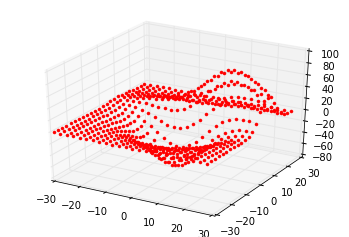

In [47]:
# 3Dグラフのサンプル
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.gca(projection="3d")

# 3Dのサンプルデータを生成する
X, Y, Z = axes3d.get_test_data(0.25)

# 3Dの点を描画する
ax.plot(X.flatten(), Y.flatten(), Z.flatten(), 'r.')

plt.show()

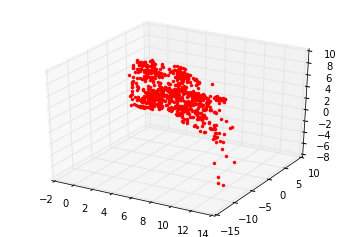

In [48]:
# 3Dの点を描画する
fig = plt.figure()
ax = fig.gca(projection="3d")

# Metron College I の3Dデータを描画する
ax.plot(points3D[0], points3D[1], points3D[2], 'r.')

plt.show()

### 5.1.3 F行列の計算---8点法
テキストp.108

8点法を計算する関数compute_fundamental()をモジュールファイルsfm.pyに追加する。



In [49]:
def compute_fundamental(x1,x2):
    """ 正規化8点法を使って対応点群(x1,x2:3*nの配列)
      から基礎行列を計算する。各列は次のような並びである。
      [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] """

    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # 方程式の行列を作成する
    A = np.zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
            x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
            x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]

    # 線形最小2乗法で計算する
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)

    # Fの制約
    # 最後の特異値を0にして階数を2にする
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))

    return F


### 5.1.4 エピ極とエピポーラ線
テキストp.109  

In [50]:
# オリジナルモジュール
import sfm

In [51]:
# 最初の2枚の画像の点のインデックス番号
# 上で計算したcorrは対応関係(correlation)を示す行列。
ndx = (corr[:, 0]>=0) & (corr[:,1]>=0)

In [52]:
# 座標値を取得し、同じ座標系にする
x1 = points2D[0][:, corr[ndx, 0]]
x1 = np.vstack((x1, np.ones(x1.shape[1])))
x2 = points2D[1][:, corr[ndx, 1]]
x2 = np.vstack((x2, np.ones(x2.shape[1])))

In [53]:
# Fを計算する
F = sfm.compute_fundamental(x1,x2)
F

array([[ -1.96006788e-06,   5.10008192e-05,  -2.61883643e-04],
       [ -4.34676703e-05,   3.19460164e-07,  -5.70330430e-02],
       [ -8.72668268e-04,   4.72929204e-02,   9.97251110e-01]])

In [54]:
# エピ極を計算する
e = sfm.compute_epipole(F)

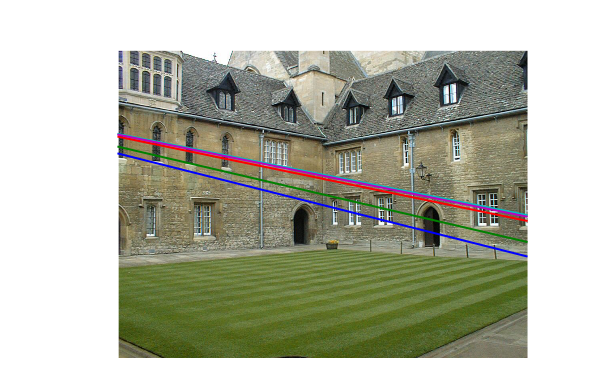

In [55]:
# 描画する
plt.figure(figsize=(10,10))
plt.imshow(im1)

# 各行について適当に色を付けて描画する
for i in range(5):
    sfm.plot_epipolar_line(im1, F, x2[:,i], e, False)
plt.axis('off')
plt.show()

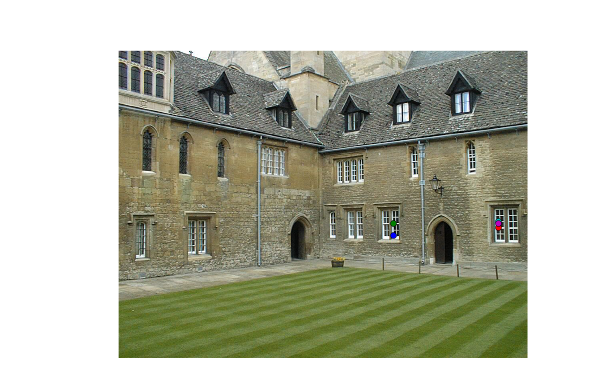

In [56]:
# エピ極をプロットする
plt.figure(figsize=(10,10))
plt.imshow(im2)
# 各点を描画する。線と同じ色付けになる。
for i in range(5):
    plt.plot(x2[0,i], x2[1,i], 'o')
plt.axis('off')

plt.show()

## 5.2 カメラと3D構造を使った計算
### 5.2.1 三角測量
テキストp.111

In [57]:
# オリジナルモジュール
import sfm

In [58]:
# 最初の2枚の画像の点のインデックス番号
ndx = (corr[:, 0]>=0) & (corr[:,1]>=0)

In [59]:
# 座標値を取得し、同じ座標系にする
x1 = points2D[0][:, corr[ndx, 0]]
x1 = np.vstack((x1, np.ones(x1.shape[1])))
x2 = points2D[1][:, corr[ndx, 1]]
x2 = np.vstack((x2, np.ones(x2.shape[1])))
Xtrue = points3D[:, ndx]
Xtrue = np.vstack((Xtrue, np.ones(Xtrue.shape[1])))

In [60]:
# 最初の3点を調べる
Xest = sfm.triangulate(x1, x2, P[0].P, P[1].P)
print(Xest[:,:3])
print(Xtrue[:,:3])

[[ 1.03743725  1.56125273  1.40720017]
 [-0.57574987 -0.55504127 -0.46523952]
 [ 3.44173797  3.44249282  7.53176488]
 [ 1.          1.          1.        ]]
[[ 1.0378863   1.5606923   1.4071907 ]
 [-0.54627892 -0.5211711  -0.46371818]
 [ 3.4601538   3.4636809   7.5323397 ]
 [ 1.          1.          1.        ]]


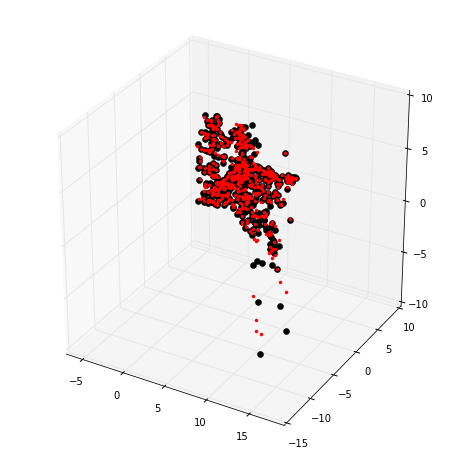

In [61]:
# 描画する
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot(Xest[0], Xest[1], Xest[2], 'ko')  # 推測点のプロット
ax.plot(Xtrue[0], Xtrue[1], Xtrue[2], 'r.')  # 実測点のプロット
plt.axis('equal')
plt.show()

### 5.2.2 3Dの点群からカメラ行列を計算する

In [62]:
import sfm, camera

In [63]:
# 第１視点
corr = corr[:,0]
# 欠けた値は-1
ndx3D = np.where(corr>=0)[0]
ndx2D = corr[ndx3D]

In [64]:
# 見える点を選び同次座標に変換
x = points2D[0][:, ndx2D] # 第１視点
x = np.vstack((x, np.ones(x.shape[1])))
X = points3D[:, ndx3D]
X = np.vstack((X, np.ones(X.shape[1])))

In [65]:
# Pを推定する
Pest = camera.Camera(sfm.compute_P(x,X))

In [66]:
# 比較する
print(Pest.P / Pest.P[2,3])
print(P[0].P / P[0].P[2,3])

xest = Pest.project(X)

[[  1.06520794e+00  -5.23431275e+01   2.06902749e+01   5.08729305e+02]
 [ -5.05773115e+01  -1.33243276e+01  -1.47388537e+01   4.79178838e+02]
 [  3.05121915e-03  -3.19264684e-02  -3.43703738e-02   1.00000000e+00]]
[[  1.06774679e+00  -5.23448212e+01   2.06926980e+01   5.08764487e+02]
 [ -5.05834364e+01  -1.33201976e+01  -1.47406641e+01   4.79228998e+02]
 [  3.06792659e-03  -3.19008054e-02  -3.43665129e-02   1.00000000e+00]]


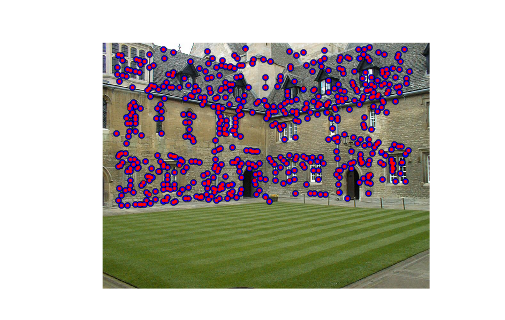

In [67]:
# 描画する
plt.figure(figsize=(8,8))
plt.imshow(im1)
plt.plot(x[0], x[1], 'bo')
plt.plot(xest[0], xest[1], 'r.')
plt.axis('off')
plt.show()